### 2-10 Generation Scheme

This generation scheme focuses on a simple yet realistic generation scheme, with a more complicated inference task.



We are moving towards a bimodal polarization distribution, which we can capture by a mixture of betas. Specifically,
$$
u_i \sim \pi \cdot \mathrm{Beta}(\alpha, \beta) + (1-\pi) \cdot \mathrm{Beta}(\beta,\alpha).
$$
However, rather than setting these parameters directly we will specify the expectation of the right peak ($\rho \in [.5,1]$), the variance ($\sigma$), and the expected proportion of left individuals ($p_l = \pi$). By solving the various systems of equations we get that 
\begin{align*}
    \alpha &= \rho \left(\frac{\rho (1-\rho)}{\sigma} - 1\right) \\
    \beta &= (1-\rho) \left(\frac{\rho (1-\rho)}{\sigma} - 1\right) \\
\end{align*}

Let's visualize this.

In [2]:
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from scipy.stats import beta
import tensorflow as tf
import tensorflow_probability as tfp

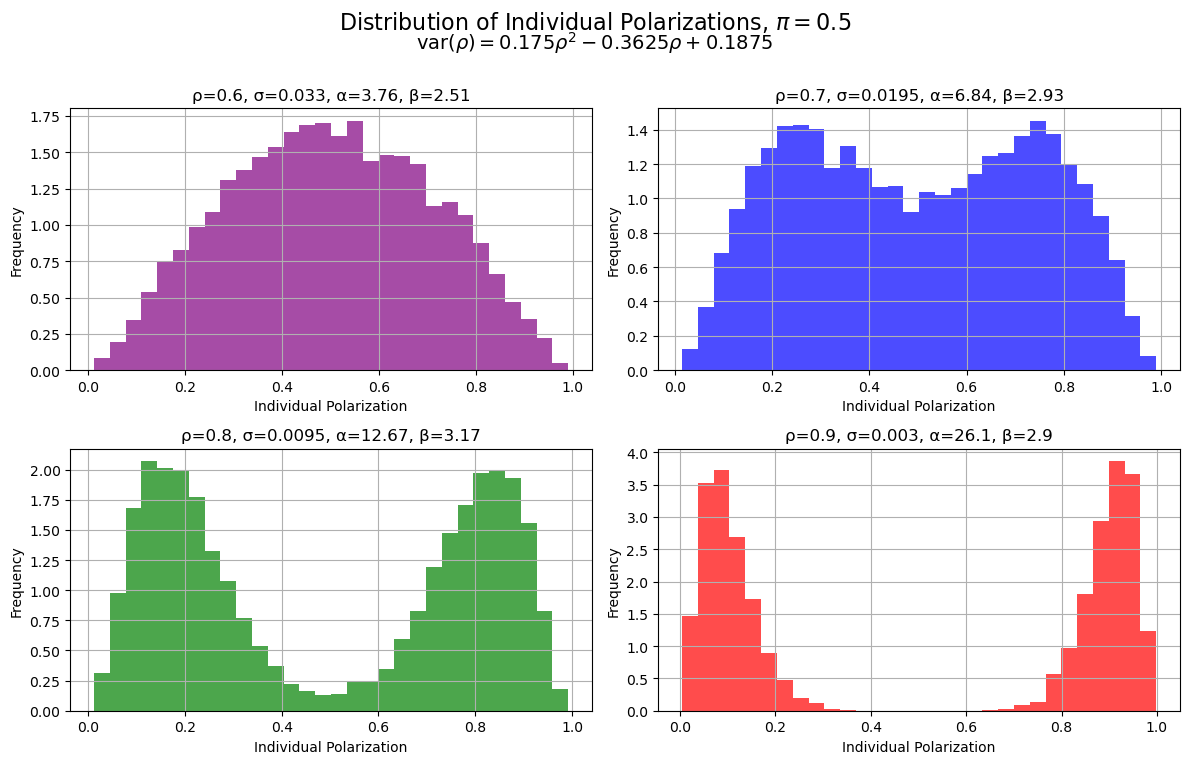

In [90]:
def get_beta_mixture(N=10000, rho=.75, sigma=0.02, pi=0.5):
    if rho * (1-rho) / sigma < 1:
        raise ValueError("rho(1-rho)/sigma must be > 1 to ensure alpha, beta > 0")

    a = rho * ((rho * (1-rho)) / sigma - 1)
    b = (1 - rho) * ((rho * (1-rho)) / sigma - 1)

    mix_decision = np.random.rand(N) < pi
    sample = np.where(mix_decision, beta.rvs(a, b, size=N), beta.rvs(b, a, size=N))
    return sample, a, b  

def plot_distributions(pi=0.5, var_func=lambda r: (.175*(r**2) - .3625*r + .1875), func_desc= r'$\mathrm{var}(\rho) = 0.175\rho^2 - 0.3625\rho + 0.1875$'):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    main_title = f'Distribution of Individual Polarizations, $\pi={pi}$'
    subtitle = func_desc
    
    fig.suptitle(main_title, fontsize=16)
    plt.figtext(0.5, 0.93, subtitle, ha='center', fontsize=14)

    colors = ['purple', 'blue', 'green', 'red']
    rhos = [.6, .7, .8, .9]

    for i, rho in enumerate(rhos):
        sigma = var_func(rho)
        sample, a, b = get_beta_mixture(rho=rho, sigma=sigma, pi=pi)
        ax = axs[i // 2, i % 2]
        ax.hist(sample, bins=30, color=colors[i], alpha=0.7, density=True)
        ax.set_title(f"ρ={rho}, σ={round(sigma, 4)}, α={round(a, 2)}, β={round(b, 2)}")
        ax.grid(True)

    for ax in axs.flat:
        ax.set(xlabel='Individual Polarization', ylabel='Frequency')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout

plot_distributions(pi=.5)

To get data to perform inference, I'm just going to skip the preprocessing and generate data in the form we need.

In [91]:
S = 15 # speech len
N = 1000 # num individuals
B = 10 # batch size 
rho = .7 
epsilon = .05 

In [92]:
def generate():
    sigma = 0.175 * (rho ** 2) - 0.3625 * rho + 0.1875
    a = rho * ((rho * (1 - rho)) / sigma - 1)
    b  = (1 - rho) * ((rho * (1 - rho)) / sigma - 1)

    u_vec = beta.rvs(a, b, size=N)
    phi_vec = [[epsilon, (1-epsilon) * (1-u), (1-epsilon) * u] for u in u_vec]
    X = np.array([np.random.multinomial(S, phi_vec[i]) for i in range(N)]) # N x 3 

    print(f"alpha: {a}")
    print(f"beta: {b}")
    return X, u_vec

In [93]:
dataset, u_vec = generate()
print(f"dataset shape: {dataset.shape}")
print(f"u_vec shape: {u_vec.shape}")

alpha: 6.838461538461533
beta: 2.930769230769229
dataset shape: (1000, 3)
u_vec shape: (1000,)


In [94]:
### priors
alpha_0 = 2. # u ~ Beta(alpha, beta)
beta_0 = 2.
wL = 4. # x ~ Softmax([wL, wR, wN].t() @ u)
wR = 2.
wN = 1.

define the generative model

In [95]:
def generative_model(alpha_0, beta_0, wL, wR, wN, S):
    W = tf.constant([wL, wR, wN], dtype=tf.float32) 
    # u ~ Beta(alpha_0, beta_0) 
    u = yield tfp.distributions.JointDistributionCoroutine.Root(
        tfp.distributions.Beta(alpha_0, beta_0, name='u')
    )
    phi = tf.nn.softmax(W * u) 
    # x | phi ~ Multinomial(phi)
    x = yield tfp.distributions.Multinomial(total_count=S, probs=phi, name='x')


model_joint = tfp.distributions.JointDistributionCoroutineAutoBatched(lambda : generative_model(alpha_0, beta_0, wL, wR, wN, S))
sample = model_joint.sample()


In [96]:
model_joint

<tfp.distributions.JointDistributionCoroutineAutoBatched 'JointDistributionCoroutineAutoBatched' batch_shape=[] event_shape=StructTuple(
  u=[],
  x=[3]
) dtype=StructTuple(
  u=float32,
  x=float32
)>

In [97]:
sample

StructTuple(
  u=<tf.Tensor: shape=(), dtype=float32, numpy=0.85879964>,
  x=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([11.,  3.,  1.], dtype=float32)>
)

For ELBO we need access to the joint log prob:

In [98]:
model_joint.log_prob(sample)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.8555608>

In [99]:
def model_joint_log_prob_fixed_data(u):
    u_batched = tf.expand_dims(u, -1) 
    return model_joint.log_prob(u_batched, dataset)

In [100]:
model_joint_log_prob_fixed_data(.6)[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-16.26305  , -13.0767565, -10.429462 , -21.371103 , -20.95956  ,
       -21.371103 , -18.561666 , -20.173265 , -10.064547 , -22.75956  ],
      dtype=float32)>

Let's now define our variational family: q(u; alpha_l, beta_l) = Beta(alpha_l, beta_l). The inital guesses are our prior guesses.

In [101]:
alpha_l0 = tfp.util.TransformedVariable(
    float(alpha_0), 
    bijector=tfp.bijectors.Softplus(), 
    name='alpha_lambda'
    )
beta_l0 = tfp.util.TransformedVariable(
    float(beta_0),
    bijector=tfp.bijectors.Softplus(),
    name='beta_lambda')

In [102]:
surrogate_posterior = tfp.distributions.Beta(alpha_l0, beta_l0, name='surrogate posterior')

In [103]:
surrogate_posterior.trainable_variables

(<tf.Variable 'beta_lambda:0' shape=() dtype=float32, numpy=1.8545866>,
 <tf.Variable 'alpha_lambda:0' shape=() dtype=float32, numpy=1.8545866>)

In [67]:
dataset.shape

(1000, 3)

In [ ]:
    samples = surrogate_posterior.sample([B])  # Sample with shape [B]
    samples = tf.expand_dims(samples, -1)  # Add dimension for broadcasting if needed
    neg_elbo = -tf.reduce_mean(
        model_joint_log_prob_fixed_data(samples) - surrogate_posterior.log_prob(samples)
    )

In [104]:
with tf.GradientTape() as g: # for backprop
    samples = surrogate_posterior.sample([B]) # idk why but erroring for more
    samples = tf.expand_dims(samples, -1)
    neg_elbo = - tf.reduce_mean(
        model_joint_log_prob_fixed_data(samples) - surrogate_posterior.log_prob(samples)
    )
        u_batched = tf.expand_dims(u, -1)  # Adds a new axis for broadcasting
    # Compute log prob in a way that handles the batch dimension
    return model_joint.log_prob(u_batched, dataset)

In [105]:
neg_elbo

<tf.Tensor: shape=(), dtype=float32, numpy=14.212674>

In [106]:
g.gradient(neg_elbo, surrogate_posterior.trainable_variables)

(<tf.Tensor: shape=(), dtype=float32, numpy=-1.2209216>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.0550184>)

In [111]:
tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model_joint_log_prob_fixed_data,
    surrogate_posterior=surrogate_posterior,
    optimizer=tf.optimizers.Adam(0.1),
    num_steps=100,
    sample_size=1
)

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([12.241741 , 12.264916 , 12.259668 , 12.13099  , 12.219413 ,
       12.210862 , 12.258619 , 12.266421 , 12.251795 , 12.238182 ,
       12.243943 , 12.245314 , 12.194205 , 12.148848 , 12.258478 ,
       12.135213 , 12.36618  , 12.230894 , 12.186284 , 12.23141  ,
       12.040562 , 12.375753 , 12.310185 , 12.285737 , 12.101563 ,
       12.242586 , 12.357177 , 12.286562 , 12.173496 , 12.077937 ,
       12.173468 , 12.296017 , 12.355829 , 12.443331 , 12.40127  ,
       12.060557 , 12.085553 , 12.226384 , 12.288122 , 12.216417 ,
       12.325154 , 12.291536 , 12.269455 , 12.212611 , 12.244733 ,
       12.2334175, 12.205054 , 12.214814 , 12.221354 , 12.068937 ,
       12.313992 , 12.144295 , 12.204873 , 12.153239 , 12.069692 ,
       12.534532 , 12.573229 , 12.17868  , 12.293669 , 12.140313 ,
       12.464678 , 12.248992 , 12.949628 , 12.451078 , 12.0483   ,
       12.293417 , 12.215505 , 12.219609 , 12.228236 , 12.109572 ,
       12.2441

In [112]:
alpha_l0

<TransformedVariable: name=alpha_lambda, dtype=float32, shape=[], fn="softplus", numpy=2.536112>

In [113]:
beta_l0

<TransformedVariable: name=beta_lambda, dtype=float32, shape=[], fn="softplus", numpy=16.561983>

In [87]:
alpha_0

2.0

In [88]:
beta_0

2.0

In [118]:
S = 15 # speech len
N = 1000 # num individuals
B = 10 # batch size 
rho = .7 
epsilon = .05 

def generate():
    sigma = 0.175 * (rho ** 2) - 0.3625 * rho + 0.1875
    a = rho * ((rho * (1 - rho)) / sigma - 1)
    b  = (1 - rho) * ((rho * (1 - rho)) / sigma - 1)

    u_vec = beta.rvs(a, b, size=N)
    phi_vec = [[epsilon, (1-epsilon) * (1-u), (1-epsilon) * u] for u in u_vec]
    X = np.array([np.random.multinomial(S, phi_vec[i]) for i in range(N)]) # N x 3 

    print(f"alpha: {a}")
    print(f"beta: {b}")
    return X, u_vec

dataset, u_vec = generate()
print(f"dataset shape: {dataset.shape}")
print(f"u_vec shape: {u_vec.shape}")

### priors
alpha_0 = 2. # u ~ Beta(alpha, beta)
beta_0 = 2.
wL = 4. # x ~ Softmax([wL, wR, wN].t() @ u)
wR = 2.
wN = 1.

def generative_model(alpha_0, beta_0, wL, wR, wN, S):
    W = tf.constant([wL, wR, wN], dtype=tf.float32) 
    # u ~ Beta(alpha_0, beta_0) 
    u = yield tfp.distributions.JointDistributionCoroutine.Root(
        tfp.distributions.Beta(alpha_0, beta_0, name='u')
    )
    phi = tf.nn.softmax(W * u) 
    # x | phi ~ Multinomial(phi)
    x = yield tfp.distributions.Multinomial(total_count=S, probs=phi, name='x')


model_joint = tfp.distributions.JointDistributionCoroutineAutoBatched(lambda : generative_model(alpha_0, beta_0, wL, wR, wN, S))
sample = model_joint.sample()
model_joint_log_prob_fixed_data = lambda u : model_joint.log_prob(u, dataset)

alpha_l0 = tfp.util.TransformedVariable(
    float(alpha_0), 
    bijector=tfp.bijectors.Softplus(), 
    name='alpha_lambda'
    )
beta_l0 = tfp.util.TransformedVariable(
    float(beta_0),
    bijector=tfp.bijectors.Softplus(),
    name='beta_lambda')

surrogate_posterior = tfp.distributions.Beta(alpha_l0, beta_l0, name='surrogate posterior')

with tf.GradientTape() as g: # for backprop
    samples  = surrogate_posterior.sample(B) # idk why but erroring for more
    neg_elbo = - tf.reduce_mean(
        model_joint_log_prob_fixed_data(samples) - surrogate_posterior.log_prob(samples)
    )

tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model_joint_log_prob_fixed_data,
    surrogate_posterior=surrogate_posterior,
    optimizer=tf.optimizers.Adam(0.1),
    num_steps=1000,
    sample_size=1
)

print(f"Trained Alpha: {alpha_l0}")
print(f"Trained Beta: {beta_l0}")

alpha: 6.838461538461533
beta: 2.930769230769229
dataset shape: (1000, 3)
u_vec shape: (1000,)


ValueError: Incompatible shapes for broadcasting. Two shapes are compatible if for each dimension pair they are either equal or one of them is 1. Received: (10,) and (1000,).